In [1]:
import numpy as np
import matplotlib.pyplot as plt
from celmech.disturbing_function import df_coefficient_Ctilde
from celmech.disturbing_function import evaluate_df_coefficient_dict
from celmech.disturbing_function import laplace_b as b
from scipy.optimize import fsolve

In [2]:
def b1(alpha):
    return b(1.5, 1, 0, alpha)
def b2(alpha):
    return b(1.5, 2, 0, alpha)

In [86]:
def Mprime(alpha, mass):
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    alpha12, alpha23, alpha13 = alpha
    
    w2 = 2*m2/(m1+m3) * (m1/(np.pi*(1-alpha23)**2) + m3/(np.pi*(1-alpha12)**2)) + 2*(m1+m3)/(np.pi*(1-alpha13)**2)
    w3 = 2*m_tot/(m1+m3) * (m1/(np.pi*(1-alpha12)**2) + m3/(np.pi*(1-alpha23)**2))
    k = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (2/(np.pi*(1-alpha23)**2) - 2/(np.pi*(1-alpha12)**2))
    phi = 1/2*np.arctan2(2*k, w2-w3)
    
    R1 = np.array([[1, 0, 0],
                    [0, np.cos(phi), np.sin(phi)],
                    [0, -np.sin(phi), np.cos(phi)]])
    R2 = np.array([[np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)],
             [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
             [np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)]])
    R = np.matmul(R1, R2)
       
    M = np.array([[b1(alpha12)*m2+b1(alpha13)*m3, -b2(alpha12)*np.sqrt(m1*m2), -b2(alpha13)*np.sqrt(m1*m3)],
             [-b2(alpha12)*np.sqrt(m1*m2), b1(alpha12)*m1+ b1(alpha23)*m3, -b2(alpha23)*np.sqrt(m2*m3)],
             [-b2(alpha13)*np.sqrt(m1*m3), -b2(alpha23)*np.sqrt(m2*m3), b1(alpha13)*m1+b1(alpha23)*m2]])*(-2*alpha[2])*np.pi/4
    
    return np.matmul(np.matmul(R, M), np.transpose(R))

In [87]:
Mprime((0.9, 0.94, 0.94*0.9),(1e-8,1e-8,1e-8))

array([[-6.04151273e-08,  2.20153695e-09,  3.34970049e-09],
       [ 2.20153695e-09, -5.46357004e-06, -2.50633520e-09],
       [ 3.34970049e-09, -2.50633520e-09, -1.80426805e-06]])

$$ R \cdot \begin{pmatrix}\vec{G_1}\\ \vec{G_2}\\ \vec{G_3} \end{pmatrix} = \begin{pmatrix}\vec{S_1}\\ \vec{S_2}\\ \vec{S_3} \end{pmatrix} $$

In [5]:
def StoG(mass, amp, phase, phi):
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    A1, A2, A3 = amp
    p1, p2, p3 = phase
    
    e1_x = 1/np.sqrt(m1) * (np.sqrt(m1/m_tot)*A1*np.cos(p1) + (-np.cos(phi)*np.sqrt(m3/(m1+m3)) + np.sin(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A2*np.cos(p2) + (np.sin(phi)*np.sqrt(m3/(m1+m3)) + np.cos(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A3*np.cos(p3))
    e2_x = 1/np.sqrt(m2) * (np.sqrt(m2/m_tot)*A1*np.cos(p1) - np.sin(phi)*np.sqrt((m1+m3)/m_tot)*A2*np.cos(p2) - np.cos(phi)*np.sqrt((m1+m3)/m_tot)*A3*np.cos(p3))
    e3_x = 1/np.sqrt(m3) * (np.sqrt(m3/m_tot)*A1*np.cos(p1) + (np.cos(phi)*np.sqrt(m1/(m1+m3)) + np.sin(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A2*np.cos(p2) + (-np.sin(phi)*np.sqrt(m1/(m1+m3)) + np.cos(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A3*np.cos(p3))
    
    e1_y = 1/np.sqrt(m1) * (np.sqrt(m1/m_tot)*A1*np.sin(p1) + (-np.cos(phi)*np.sqrt(m3/(m1+m3)) + np.sin(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A2*np.sin(p2) + (np.sin(phi)*np.sqrt(m3/(m1+m3)) + np.cos(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A3*np.sin(p3))
    e2_y = 1/np.sqrt(m2) * (np.sqrt(m2/m_tot)*A1*np.sin(p1) - np.sin(phi)*np.sqrt((m1+m3)/m_tot)*A2*np.sin(p2) - np.cos(phi)*np.sqrt((m1+m3)/m_tot)*A3*np.sin(p3))
    e3_y = 1/np.sqrt(m3) * (np.sqrt(m3/m_tot)*A1*np.sin(p1) + (np.cos(phi)*np.sqrt(m1/(m1+m3)) + np.sin(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A2*np.sin(p2) + (-np.sin(phi)*np.sqrt(m1/(m1+m3)) + np.cos(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A3*np.sin(p3))
    
    e1, e2, e3 = np.sqrt(e1_x**2 + e1_y**2), np.sqrt(e2_x**2 + e2_y**2), np.sqrt(e3_x**2 + e3_y**2)
    pom1, pom2, pom3 = np.arctan2(e1_y,e1_x), np.arctan2(e2_y,e2_x), np.arctan2(e3_y,e3_x)
    
    return (e1, e2, e3), (pom1, pom2, pom3)

In [6]:
def GtoS(alpha, mass, ecc, pomega):
    alpha12, alpha23 = alpha
    alpha13 = alpha12*alpha23
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    ecc1, ecc2, ecc3 = ecc
    pom1, pom2, pom3 = pomega

    e1_x, e2_x, e3_x = ecc1*np.cos(pom1), ecc2*np.cos(pom2), ecc3*np.cos(pom3)
    e1_y, e2_y, e3_y = ecc1*np.sin(pom1), ecc2*np.sin(pom2), ecc3*np.sin(pom3)
    
    w2 = 2*m2/(m1+m3) * (m1/(np.pi*(1-alpha23)**2) + m3/(np.pi*(1-alpha12)**2)) + 2*(m1+m3)/(np.pi*(1-alpha13)**2)
    w3 = 2*m_tot/(m1+m3) * (m1/(np.pi*(1-alpha12)**2) + m3/(np.pi*(1-alpha23)**2))
    k = np.sqrt(m1*m2*m3*m_tot)/(m1+m3) * (2/(np.pi*(1-alpha23)**2) - 2/(np.pi*(1-alpha12)**2))
    phi = 1/2*np.arctan2(2*k, w2-w3)
    
    S1_x = np.sqrt(1/m_tot)*(m1*e1_x + m2*e2_x + m3*e3_x)
    S1_y = np.sqrt(1/m_tot)*(m1*e1_y + m2*e2_y + m3*e3_y)
    S2_x = np.cos(phi)*(np.sqrt(m1*m3/(m1+m3))*(e3_x-e1_x)) + np.sin(phi)*np.sqrt(m2/((m1+m3)*m_tot))*(m3*(e3_x-e2_x)-m1*(e2_x-e1_x))
    S2_y = np.cos(phi)*(np.sqrt(m1*m3/(m1+m3))*(e3_y-e1_y)) + np.sin(phi)*np.sqrt(m2/((m1+m3)*m_tot))*(m3*(e3_y-e2_y)-m1*(e2_y-e1_y))
    S3_x = -np.sin(phi)*(np.sqrt(m1*m3/(m1+m3))*(e3_x-e1_x)) + np.cos(phi)*np.sqrt(m2/((m1+m3)*m_tot))*(m3*(e3_x-e2_x)-m1*(e2_x-e1_x))
    S3_y = -np.sin(phi)*(np.sqrt(m1*m3/(m1+m3))*(e3_y-e1_y)) + np.cos(phi)*np.sqrt(m2/((m1+m3)*m_tot))*(m3*(e3_y-e2_y)-m1*(e2_y-e1_y))
    
    amp1, amp2, amp3 = np.sqrt(S1_x**2+S1_y**2), np.sqrt(S2_x**2+S2_y**2), np.sqrt(S3_x**2+S3_y**2)
    phase1, phase2, phase3 = np.arctan2(S1_y,S1_x), np.arctan2(S2_y,S2_x), np.arctan2(S3_y,S3_x)
    omega2, omega3 = w2*(np.cos(phi))**2 + k*np.sin(2*phi) + w3*(np.sin(phi))**2, w2*(np.sin(phi))**2 - k*np.sin(2*phi) + w3*(np.cos(phi))**2
    
    return amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3, phi

In [7]:
def breathingON(mass, phase, phi, A3_p):
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    p1, p2, p3 = phase
    
    x1 = np.cos(phi)*np.sqrt(m3/(m1*(m1+m3))) - np.sin(phi)*np.sqrt(m2/(m_tot*(m1+m3))) - np.sin(phi)*np.sqrt((m1+m3)/(m2*m_tot))
    x2 = np.sin(phi)*np.sqrt(m3/(m1*(m1+m3))) + np.cos(phi)*np.sqrt(m2/(m_tot*(m1+m3))) + np.cos(phi)*np.sqrt((m1+m3)/(m2*m_tot))
    y1 = np.cos(phi)*np.sqrt(m1/(m3*(m1+m3))) + np.sin(phi)*np.sqrt(m2/(m_tot*(m1+m3))) + np.sin(phi)*np.sqrt((m1+m3)/(m2*m_tot))
    y2 = -np.sin(phi)*np.sqrt(m1/(m3*(m1+m3))) + np.cos(phi)*np.sqrt(m2/(m_tot*(m1+m3))) + np.cos(phi)*np.sqrt((m1+m3)/(m2*m_tot))
    
    def equations(p):
        A2, A3 = p
        return (x1**2*A2**2 - 2*x1*x2*A2*A3*np.cos(p3-p2) + x2**2*(A3**2-A3_p**2), y1**2*A2**2 + 2*y1*y2*A2*A3*np.cos(p3-p2) + y2**2*(A3**2-A3_p**2))

    A2_b, A3_b =  fsolve(equations, (A3_p, A3_p))
    return A2_b, A3_b

In [8]:
def plotEcc(alpha, mass, ecc, pomega, time):
    m1, m2, m3 = mass
    m_tot = m1+m2+m3
    A1, A2, A3, p1, p2, p3, w2, w3, phi = GtoS(alpha, mass, ecc, pomega)
    print(f"A1={A1},A2={A2},A3={A3}")
    print(f"w2={w2},w3={w3}")
    
    t = np.linspace(0,time,400)
    
    e1_x = 1/np.sqrt(m1) * (np.sqrt(m1/m_tot)*A1*np.cos(p1) + (-np.cos(phi)*np.sqrt(m3/(m1+m3)) + np.sin(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A2*np.cos(w2*t+p2) + (np.sin(phi)*np.sqrt(m3/(m1+m3)) + np.cos(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A3*np.cos(w3*t+p3))
    e2_x = 1/np.sqrt(m2) * (np.sqrt(m2/m_tot)*A1*np.cos(p1) - np.sin(phi)*np.sqrt((m1+m3)/m_tot)*A2*np.cos(w2*t+p2) - np.cos(phi)*np.sqrt((m1+m3)/m_tot)*A3*np.cos(w3*t+p3))
    e3_x = 1/np.sqrt(m3) * (np.sqrt(m3/m_tot)*A1*np.cos(p1) + (np.cos(phi)*np.sqrt(m1/(m1+m3)) + np.sin(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A2*np.cos(w2*t+p2) + (-np.sin(phi)*np.sqrt(m1/(m1+m3)) + np.cos(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A3*np.cos(w3*t+p3))
    
    e1_y = 1/np.sqrt(m1) * (np.sqrt(m1/m_tot)*A1*np.sin(p1) + (-np.cos(phi)*np.sqrt(m3/(m1+m3)) + np.sin(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A2*np.sin(w2*t+p2) + (np.sin(phi)*np.sqrt(m3/(m1+m3)) + np.cos(phi)*np.sqrt(m1*m2/(m_tot*(m1+m3))))*A3*np.sin(w3*t+p3))
    e2_y = 1/np.sqrt(m2) * (np.sqrt(m2/m_tot)*A1*np.sin(p1) - np.sin(phi)*np.sqrt((m1+m3)/m_tot)*A2*np.sin(w2*t+p2) - np.cos(phi)*np.sqrt((m1+m3)/m_tot)*A3*np.sin(w3*t+p3))
    e3_y = 1/np.sqrt(m3) * (np.sqrt(m3/m_tot)*A1*np.sin(p1) + (np.cos(phi)*np.sqrt(m1/(m1+m3)) + np.sin(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A2*np.sin(w2*t+p2) + (-np.sin(phi)*np.sqrt(m1/(m1+m3)) + np.cos(phi)*np.sqrt(m2*m3/(m_tot*(m1+m3))))*A3*np.sin(w3*t+p3))
    
    e1 = np.sqrt(e1_x**2 + e1_y**2)
    e2 = np.sqrt(e2_x**2 + e2_y**2)
    e3 = np.sqrt(e3_x**2 + e3_y**2)
    
    e21 = np.sqrt((e2_x-e1_x)**2 + (e2_y-e1_y)**2)
    e32 = np.sqrt((e3_x-e2_x)**2 + (e3_y-e2_y)**2)
    
    fig, axarr = plt.subplots(nrows=5, figsize=(12,14))
    axarr[0].plot(t, e1, 'k.')
    axarr[0].set_ylabel(r"$e_{1}$")
    
    axarr[1].plot(t, e2, 'k.')
    axarr[1].set_ylabel(r"$e_{2}$")
    
    axarr[2].plot(t, e3, 'k.')
    axarr[2].set_ylabel(r"$e_{3}$")
    
    axarr[3].plot(t, e21, 'k.')
    axarr[3].set_ylabel(r"$e_{21}$")
    
    axarr[4].plot(t, e32, 'k.')
    axarr[4].set_ylabel(r"$e_{32}$")
    

In [106]:
alpha = 0.85, 0.9
mass = 2e-8,1e-8,1e-8
ecc = 0.02, 0.02, 0.02
pomega = 0, 0, np.pi
amp1, amp2, amp3, phase1, phase2, phase3, omega2, omega3, phi = GtoS(alpha, mass, ecc, pomega)
# print(amp1, amp3, amp3)
# print(phase1, phase2, phase3)

A1=2e-06,A2=4.3598209387020825e-23,A3=2.6338245871222485e-06
w2=1.7315813990388615e-06,w3=7.363168885910113e-07


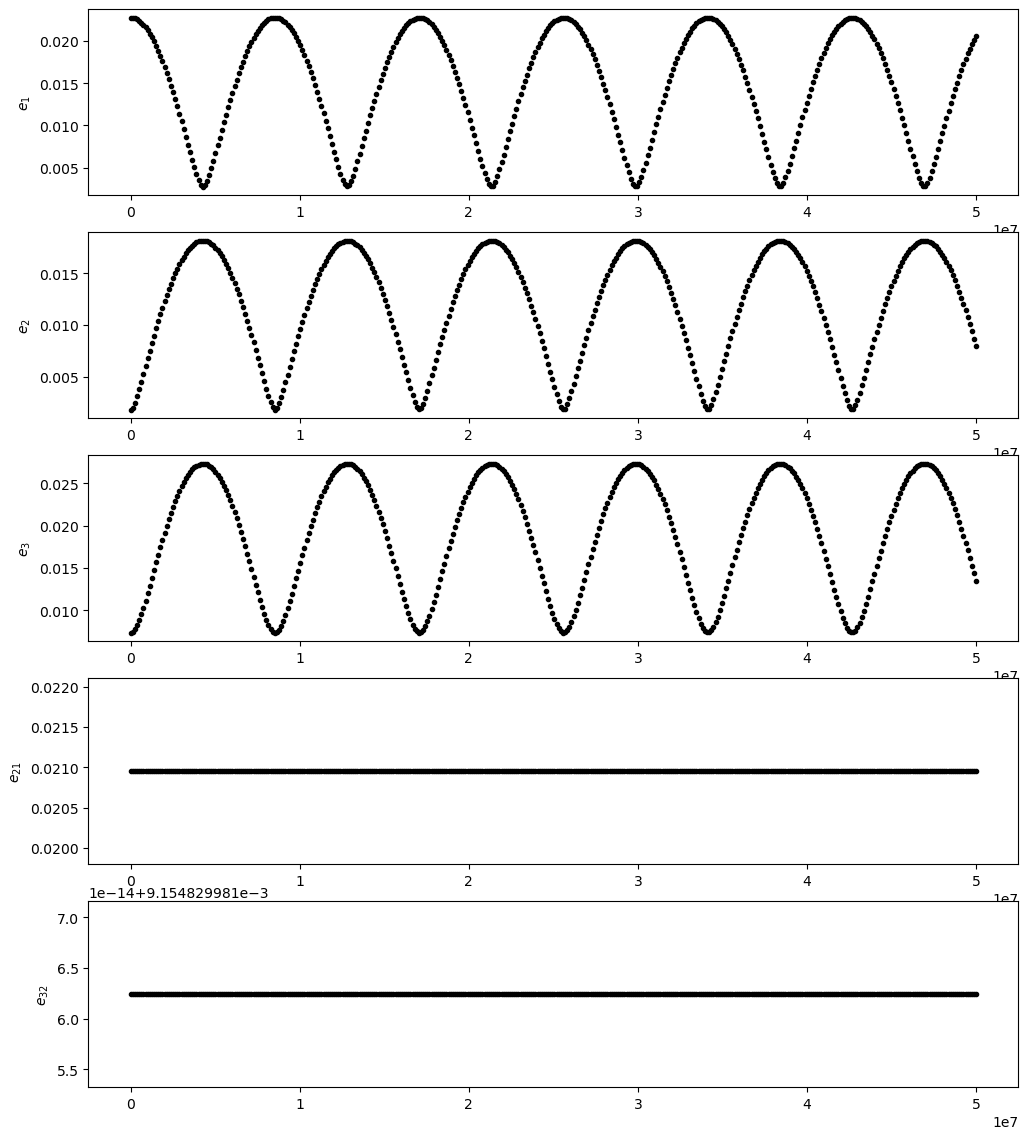

In [107]:
ecc, pomega = StoG(mass, (amp1, 0, amp3), (phase1, phase2, phase3), phi)
plotEcc(alpha, mass, ecc, pomega,5e7)

A1=2.0000000000000003e-06,A2=1.0299659813661965e-06,A3=1.4282137724081934e-06
w2=1.7315813990388615e-06,w3=7.363168885910113e-07


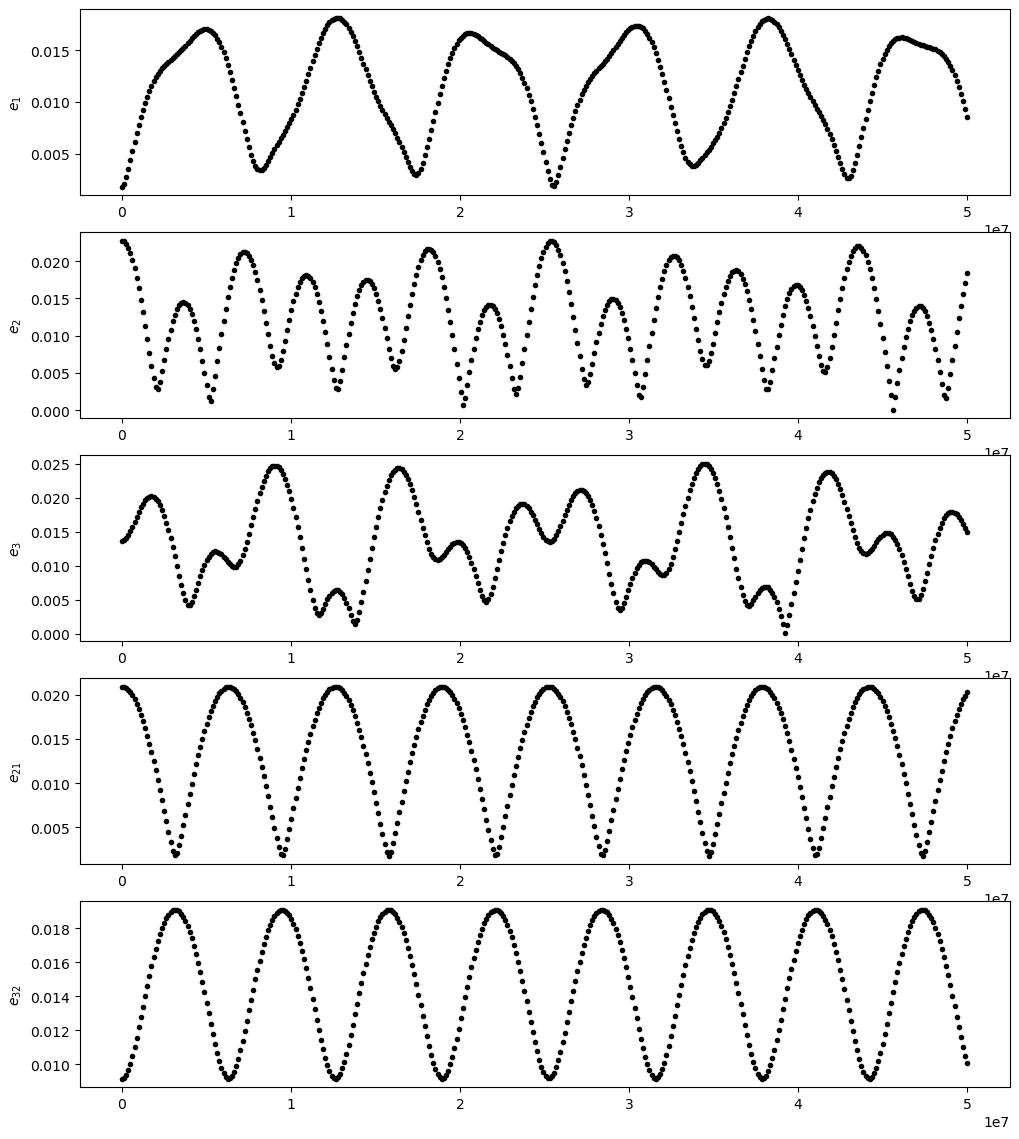

In [108]:
A2_b, A3_b = breathingON(mass, (phase1,phase2,phase3), phi, amp3)
ecc, pomega = StoG(mass, (amp1, A2_b, A3_b), (phase1, phase2, phase3), phi)
plotEcc(alpha, mass, ecc, pomega, 5e7)